<p>For data cleaning part see this notebook <a href='https://github.com/shoabahamed/warner_bros_films_database/blob/main/scapping_warner_bros_films.ipynb'> scapping_warner_bros_films.ipynb</a></p>

<p>For data cleaning part see this notebook <a href='https://github.com/shoabahamed/warner_bros_films_database/blob/main/data_cleaning.ipynb'> data_cleaning.ipynb</a></p>

<p>For data analysis part see this notebook <a href='https://github.com/shoabahamed/warner_bros_films_database/blob/main/analyzing_waner_bros_movie_dataset.ipynb'> analyzing_waner_bros_movie_dataset.ipynb</a></p>

<h3>The goal of this project is to scrap warner bros films datas from (2010 - 2019) from wikipedia
    <a href='https://en.wikipedia.org/wiki/List_of_Warner_Bros._films_(2010–2019)'> List_of_Warner_Bros._films_(2010–2019)</a>with beautiful soup library and clean the dataset afterwards</h3>

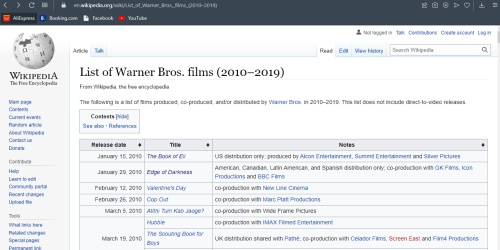

<p>Importing necessary modules and library for this project</p>

In [1]:
from bs4 import BeautifulSoup
import requests
import time
import json

<p>First lets try to get the data from a single move site first</p>

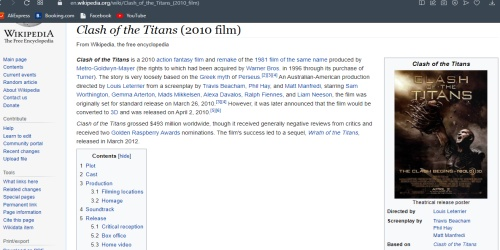

<p>getting the html text file as response from requests.get()</p>

In [23]:
response = requests.get('https://en.wikipedia.org/wiki/Clash_of_the_Titans_(2010_film)')
html_text = response.text
print(html_text[:500])

<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>Clash of the Titans (2010 film) - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":false,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"ca149500-ed38-431c-b8


<p>passing the text file to Beautiful soup for parsing</p>

In [24]:
soup = BeautifulSoup(html_text, 'lxml')
type(soup)

bs4.BeautifulSoup

In [26]:
table = soup.find('table', class_='infobox vevent') # selecting the table containing all the info

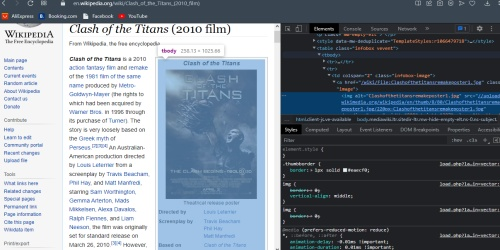

<p>Getting all the rows in the table</p>

In [27]:
rows = table.find_all('tr')
rows[:3]

[<tr><th class="infobox-above summary" colspan="2" style="font-size: 125%; font-style: italic;">Clash of the Titans</th></tr>,
 <tr><td class="infobox-image" colspan="2"><a class="image" href="/wiki/File:Clashofthetitansremakeposter1.jpg"><img alt="Clashofthetitansremakeposter1.jpg" class="thumbborder" data-file-height="385" data-file-width="259" decoding="async" height="327" src="//upload.wikimedia.org/wikipedia/en/thumb/8/80/Clashofthetitansremakeposter1.jpg/220px-Clashofthetitansremakeposter1.jpg" srcset="//upload.wikimedia.org/wikipedia/en/8/80/Clashofthetitansremakeposter1.jpg 1.5x" width="220"/></a><div class="infobox-caption">Theatrical release poster</div></td></tr>,
 <tr><th class="infobox-label" scope="row" style="white-space: nowrap; padding-right: 0.65em;">Directed by</th><td class="infobox-data"><a href="/wiki/Louis_Leterrier" title="Louis Leterrier">Louis Leterrier</a></td></tr>]

<h3>Functions to get the datas from each row and handle edge cases</h3>

In [29]:
def get_row_data_values(row_datas):
    if row_datas.find('li') or row_datas.find('br'): # when the key has multiple values in it
        return [text.replace('\xa0', '') for text in row_datas.stripped_strings 
                if ')' not in text  if '(' not in text]
    
    return row_datas.get_text(strip=True).replace('\xa0', '') # replacing \xa0 to make the text clean


# removing sup and span tags from each row to remove any extra words or references that we don't need
def remove_tags(row_datas):
    for sup in row_datas.find_all('sup'):
        sup.decompose()
        
    for span in row_datas.find_all('span'):
        span.decompose()
        
    return row_datas
    

In [30]:
info_table = {}

for index, row in enumerate(rows):
    if index == 0:
        info_table["Title"] = row.text # only has one column so just getting the text would do
        continue
    elif index == 1:     
        continue                       # ignoring the row containing the picture
    if not row.find('th'):
        continue                       # not taking rows if they do not have two columns
        
        
    row_name = row.find('th').text                       # getting key name
    row_datas = row.find("td", class_='infobox-data')    # selecting key values
    cln_row_datas = remove_tags(row_datas)               # removing sup and super tag
    
    
    if row_name == "Based on": # edge case
        row_data_values = cln_row_datas.get_text(',', strip=True)
        info_table[row_name] = row_data_values
        continue
        
    row_data_values = get_row_data_values(cln_row_datas)         # getting key values
    
    info_table[row_name] = row_data_values                      # adding to dictonary

info_table

{'Title': 'Clash of the Titans',
 'Directed by': 'Louis Leterrier',
 'Screenplay by': ['Travis Beacham', 'Phil Hay', 'Matt Manfredi'],
 'Based on': 'Clash of the Titans,by,Beverley Cross',
 'Produced by': ['Basil Iwanyk', 'Kevin De La Noy', 'Richard D. Zanuck'],
 'Starring': ['Sam Worthington',
  'Gemma Arterton',
  'Mads Mikkelsen',
  'Alexa Davalos',
  'Ralph Fiennes',
  'Liam Neeson'],
 'Cinematography': 'Peter Menzies Jr.',
 'Edited by': ['Vincent Tabaillon', 'Martin Walsh'],
 'Music by': 'Ramin Djawadi',
 'Productioncompanies': ['Legendary Pictures',
  'The Zanuck Company',
  'Thunder Road Pictures'],
 'Distributed by': 'Warner Bros. Pictures',
 'Release date': ['April2,2010'],
 'Running time': '108 minutes',
 'Countries': ['United States', 'Australia'],
 'Language': 'English',
 'Budget': '$125 million',
 'Box office': '$493.2 million'}

<h3>Now lets take all the movie pages paths for the wikipedia warner bros 2010 - 2019 movie list</h3>

<p>Getting all the links of movie pages of <b>2010-1019</b></p>

In [3]:
markup = requests.get('https://en.wikipedia.org/wiki/List_of_Warner_Bros._films_(2010–2019)').text
soup = BeautifulSoup(markup, 'lxml')

<p>Selecting the movie list table</p>

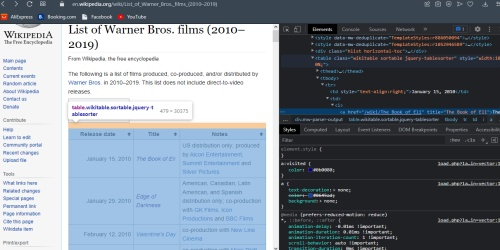

In [4]:
table_list = soup.find("table", class_='wikitable sortable')

In [18]:
movie_rows = table_list.find_all('tr') # selecting all the rows
len(movie_rows)

375

In [17]:
movie_paths = []

movie_rows = table_list.find_all('tr')

for index, movie_row in enumerate(movie_rows):
    try:
        
        if index == 0:  # ignoring the headers
            continue

        movie_title = movie_row.find('i')
        relative_path = movie_title.find('a')['href']           # getting headers
        abs_path = 'https://en.wikipedia.org' + relative_path  

        movie_paths.append(abs_path)

        if index%50 == 0:
            print(index)

        time.sleep(2)
        
    except:
        print('Link not found')

Link not found
Link not found
50
Link not found
100
150
Link not found
Link not found
200
Link not found
Link not found
250
Link not found
300
Link not found
350


In [19]:
len(movie_paths)

365

<h4>Lets save the paths to json file to use it later</h4>

In [20]:
with open('./files/movie_paths.json', "w", encoding='utf-8') as file:
    json.dump(movie_paths, file, ensure_ascii=False, indent=2)

<p>lets load the paths</p>

In [31]:
with open('./files/movie_paths.json', 'r', encoding='utf-8') as file:
    movie_paths = json.load(file)

len(movie_paths)

365

In [22]:
print(movie_paths[10])

https://en.wikipedia.org/wiki/Clash_of_the_Titans_(2010_film)


<p>Lets get the information for each wavepage and store them in a list</p>

In [24]:
# a function that returns the table information(from previous cell)
def get_table(soup):
    info_table = {}
    
    table = soup.find('table', class_='infobox vevent')
    rows = table.find_all('tr')
    
    for index, row in enumerate(rows):
        if index == 0:
            info_table["Title"] = row.text
            continue
        elif index == 1:
            continue
        if not row.find('th'):
            continue

        row_name = row.find('th').text
        row_datas = row.find("td", class_='infobox-data')
        cln_row_datas = remove_tags(row_datas)

        if row_name == "Based on":
            row_data_values = cln_row_datas.get_text(',', strip=True)
            info_table[row_name] = row_data_values
            continue

        row_data_values = get_row_data_values(cln_row_datas)

        info_table[row_name] = row_data_values
        
    return info_table

In [29]:
movie_dataset = []

for index, path in enumerate(movie_paths):
    try:
        
        info_table = {}

        markup = requests.get(path).text
        soup = BeautifulSoup(markup, 'lxml')

        table = get_table(soup)
        title = path.split('/')[-1]

        info_table[title] = table
        movie_dataset.append(info_table)
        time.sleep(2)
        
        if index % 100 == 0:
            print(index)
            
    except:
        print(f'{index} could not scrap table for path: {path}')

0
41 could not scrap table for path: https://en.wikipedia.orghttps://it.wikipedia.org/wiki/La_bellezza_del_somaro
48 could not scrap table for path: https://en.wikipedia.orghttps://pl.wikipedia.org/wiki/Jak_si%C4%99_pozby%C4%87_cellulitu
100
103 could not scrap table for path: https://en.wikipedia.orghttps://tr.wikipedia.org/wiki/%C3%87anakkale_%C3%87ocuklar%C4%B1
106 could not scrap table for path: https://en.wikipedia.orghttps://tr.wikipedia.org/wiki/O%C4%9Flum_Bak_Git
109 could not scrap table for path: https://en.wikipedia.orghttps://tr.wikipedia.org/wiki/%C3%87akallarla_Dans_2:_Hastas%C4%B1y%C4%B1z_Dede
118 could not scrap table for path: https://en.wikipedia.orghttps://tr.wikipedia.org/wiki/Hititya:_Madalyonun_S%C4%B1rr%C4%B1
138 could not scrap table for path: https://en.wikipedia.orghttps://tr.wikipedia.org/wiki/Vay_Ba%C5%9F%C4%B1ma_Gelenler
145 could not scrap table for path: https://en.wikipedia.orghttps://tr.wikipedia.org/wiki/Kedi_%C3%96zledi
147 could not scrap table for p

In [32]:
print(f'From {len(movie_paths)} movie paths we were able to get {len(movie_dataset)}')

From 365 movie paths we were able to get 335


In [32]:
movie_dataset[-50]

{'Rampage_(2018_film)': {'Title': 'Rampage',
  'Directed by': 'Brad Peyton',
  'Screenplay by': ['Ryan Engle',
   'Carlton Cuse',
   'Ryan J. Condal',
   'Adam Sztykiel'],
  'Story by': 'Ryan Engle',
  'Based on': 'Rampage,by,Midway Games',
  'Produced by': ['Dwayne Johnson',
   'Brad Peyton',
   'Beau Flynn',
   'John Rickard',
   'Hiram Garcia'],
  'Starring': ['Dwayne Johnson',
   'Naomie Harris',
   'Malin Åkerman',
   'Joe Manganiello',
   'Jake Lacy',
   'Marley Shelton',
   'Jeffrey Dean Morgan'],
  'Cinematography': 'Jaron Presant',
  'Edited by': ['Jim May', 'Bob Ducsay'],
  'Music by': 'Andrew Lockington',
  'Productioncompanies': ['New Line Cinema',
   'Access Entertainment',
   'Dune Entertainment',
   'Flynn Picture Company',
   'Wrigley Pictures',
   'ASAP Entertainment',
   'Seven Bucks Productions'],
  'Distributed by': 'Warner Bros. Pictures',
  'Release dates': ['April4,2018', 'Microsoft Theater', 'April13,2018'],
  'Running time': '107 minutes',
  'Country': 'United 

<h2>Now we need to add imdb ranking, rotten tomato score to the dataset</h2>

<h3>We can get the values through <a href='https://www.omdbapi.com'>omdbaapi.com</a> which is movie database api website</h3>

In [21]:
params = {
    'apikey': '4d3b5eab',
    't' : 'Cop Out'
}
response = requests.get('http://www.omdbapi.com', params=params).json()   # gets a response and
                                                                          # return json file
response

{'Title': 'Cop Out',
 'Year': '2010',
 'Rated': 'R',
 'Released': '26 Feb 2010',
 'Runtime': '107 min',
 'Genre': 'Action, Comedy, Crime',
 'Director': 'Kevin Smith',
 'Writer': 'Robb Cullen, Mark Cullen',
 'Actors': 'Bruce Willis, Tracy Morgan, Juan Carlos Hernández',
 'Plot': "Jimmy's rare baseball card is robbed. Since it's his only hope to pay for his daughter's upcoming wedding, he recruits his cop partner Paul to track down the robber, a memorabilia-obsessed gangster.",
 'Language': 'English, Spanish',
 'Country': 'United States',
 'Awards': '1 nomination',
 'Poster': 'https://m.media-amazon.com/images/M/MV5BMTk0NzcxMjYwNF5BMl5BanBnXkFtZTcwMTI4MTIxMw@@._V1_SX300.jpg',
 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '5.6/10'},
  {'Source': 'Rotten Tomatoes', 'Value': '18%'},
  {'Source': 'Metacritic', 'Value': '31/100'}],
 'Metascore': '31',
 'imdbRating': '5.6',
 'imdbVotes': '87,845',
 'imdbID': 'tt1385867',
 'Type': 'movie',
 'DVD': '20 Jul 2010',
 'BoxOffice': '$44

In [4]:
print(response['imdbRating'])
print(response['imdbVotes'])
print(response['Ratings'][1].get('Value'))

5.6
87,845
18%


In [5]:
def get_value(json_data, key):
    return json_data.get(key, "NAN")    # getting each key values

def get_rotten_tomatoes(json_data, key):  # getting rotten tomatoes score which are kinda hard to get
    try:
        return json_data.get('Ratings')[1].get('Value')
    except:
        return 'NAN'

In [13]:
for index, info in enumerate(movie_dataset):
    for title, table in info.items():
        try:
            params = {
                'apikey': '4d3b5eab',
                't' : table['Title']
            }
            
            json_data = requests.get('http://www.omdbapi.com', params=params).json()  

            imdb_rating = get_value(json_data, 'imdbRating')
            imdb_votes = get_value(json_data, 'imdbVotes')            # getting values
            metascore = get_value(json_data, 'Metascore')
            rotten_tomatoes = get_rotten_tomatoes(json_data, 'Ratings')

            table['ImdbRating'] = imdb_rating
            table['MetaScore'] = metascore                   # adding to movie dataset
            table['ImdbVotes'] = imdb_votes                 
            table['Rotten Tomatoes'] = rotten_tomatoes


            if index % 30 == 0:
                print(f'The index number is {index} movie name {title}')

            time.sleep(2)
        
        except:
            print(f'Was not able to fetch {table["Title"]}')
            

The index number is 0 movie name The_Book_of_Eli
The index number is 30 movie name Ramayana:_The_Epic
The index number is 60 movie name Nicostratos_the_Pelican
The index number is 90 movie name To_the_Arctic_3D
The index number is 120 movie name The_Great_Gatsby_(2013_film)
The index number is 150 movie name Blended_(film)
The index number is 180 movie name Get_Hard
The index number is 210 movie name How_to_Be_Single
The index number is 240 movie name Vier_gegen_die_Bank_(2016_film)
The index number is 270 movie name Ayla:_The_Daughter_of_War
The index number is 300 movie name Fantastic_Beasts:_The_Crimes_of_Grindelwald
The index number is 330 movie name My_Zoe


In [14]:
movie_dataset[3]

{'Cop_Out_(2010_film)': {'Title': 'Cop Out',
  'Directed by': 'Kevin Smith',
  'Written by': ['Robb Cullen', 'Mark Cullen'],
  'Produced by': ['Marc Platt', 'Polly Johnsen', 'Michael Tadross'],
  'Starring': ['Bruce Willis',
   'Tracy Morgan',
   'Adam Brody',
   'Kevin Pollak',
   'Guillermo Diaz',
   'Seann William Scott'],
  'Cinematography': 'Dave Klein',
  'Edited by': 'Kevin Smith',
  'Music by': 'Harold Faltermeyer',
  'Productioncompany': 'Marc Platt Productions',
  'Distributed by': 'Warner Bros. Pictures',
  'Release date': ['February26,2010'],
  'Running time': '107 minutes',
  'Country': 'United States',
  'Language': 'English',
  'Budget': '$30 million',
  'Box office': '$55.6 million',
  'ImdbRating': '5.6',
  'MetaScore': '31',
  'ImdbVotes': '87,845',
  'Rotten Tomatoes': '18%'}}

<h3>From 365 webpages we were able to scrap 335 pages. The ones weren't age to get are not written in English or 
is not a movie. Now lets save the data into a json file</h3>

In [15]:
with open('./files/movie_dataset.json', "w", encoding='utf-8') as file:
    json.dump(movie_dataset, file, ensure_ascii=False, indent=4)

<h1>The data collection part is now completed right now we need to clean it</h1>
<H3><b>Check the
<a href='https://github.com/shoabahamed/warner_bros_films_database/blob/main/data_cleaning.ipynb'>
    data_cleaning.ipynb</a> notebook for cleaning the movie_dataset<H3>